In [1]:
import numpy as np
from numpy.random import choice

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.autograd.functional import jacobian

import math

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!pip install cmasher
import cmasher as cmr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.3/533.3 kB 7.8 MB/s eta 0:00:00


In [3]:
# It is recommended data is saved elsewhere for access, i.e. google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


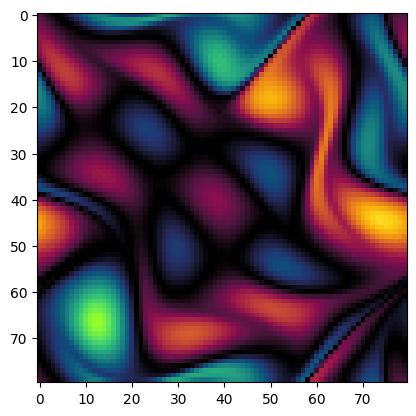

In [4]:
# Load Navier-Stokes data
NS = np.load("/content/drive/MyDrive/navier_stokes_solutions.pth.npy") # Load in data

# Create new data, reducing dimension if necessary
NS_lowres = NS[:,:,:,:]
plt.imshow(NS_lowres[0,19,:,:], cmap=cmr.wildfire)

NS_lowres_tens = torch.from_numpy(NS_lowres).type(torch.float32).to(device)
NS_lowres_tens_0 = torch.unsqueeze(NS_lowres_tens[:,0,:,:],dim=1)

In [5]:
# Prepare data

# Create relevant discretizations
N_x = NS_lowres_tens.size(dim=2)
Lt = 1.0
N_t = 20
T = np.linspace(0, Lt, N_t)
T = torch.from_numpy(T)

num_samples = 2000  # Number of Navier-Stokes solutions
num_ICs = 20*num_samples   # Number of grids to be used as training data paired with a random time for output; should be >> num_samples


# Navier-Stokes equation data for neural network input
U = torch.zeros(size=(num_ICs, 1, N_x, N_x)).to(device)
V = torch.zeros(size=(num_ICs, 1, N_x, N_x)).to(device)
times = torch.zeros(size=(num_ICs,1)).to(device)

for num in range(num_ICs):

  rand_i = num % num_samples #np.random.randint(0,num_samples,1)
  time_index = np.random.randint(0, T.size(), 1) #np.random.randint(0, T.size(), 1)

  # Add additional data for final time if desired
  if num > (num_ICs - 1e4):
    time_index = 19

  U[num,:,:,:] = NS_lowres_tens[rand_i,0,:,:]
  times[num,0] = T[time_index]
  V[num,:,:,:] = NS_lowres_tens[rand_i,time_index,:,:]

In [6]:
class parameterization_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv1 = nn.Conv2d(1, 10, 5)
    self.conv2 = nn.Conv2d(10, 4, 5)
    self.linear1 = nn.Linear(1156, 500, bias=True)
    self.linear2 = nn.Linear(500, 200, bias=True)
    self.linear3 = nn.Linear(200, 100, bias=True)   # 100 is for domain of 100-sphere embedded in R^{101}
   # self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    x = self.pool(F.gelu(self.conv1(x)))
    x = self.pool(F.gelu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.gelu(self.linear1(x))
    x = F.gelu(self.linear2(x))
    x = self.linear3(x)
    return x

In [7]:
# Neural network to allow sphere to drift in space to achieve intrinsic manifold behavior
class sphere_shift_NN(nn.Module):
    def __init__(self):
      super().__init__()
      self.linear1 = nn.Linear(1, 80, bias=True)
      self.linear2 = nn.Linear(80, 80, bias=True)
      self.linear3 = nn.Linear(80, 101, bias=True)

    def forward(self, x):
      x = F.gelu(self.linear1(x))
      x = F.gelu(self.linear2(x))
      x = self.linear3(x)
      return x

In [8]:
# Decodes from point along sphere to solution
class decoder_NN(nn.Module):
    def __init__(self):
      super().__init__()
      self.linear1 = nn.Linear(101, 400, bias=True)
      self.linear2 = nn.Linear(400, 1600, bias=True)
      self.linear3 = nn.Linear(1600, 6400, bias=True)
      self.linear4 = nn.Linear(6400, 6400, bias=True)
      self.linear5 = nn.Linear(6400, 6400, bias=True)
      self.dropout1 = nn.Dropout(0.25)
      self.dropout2 = nn.Dropout(0.35)

    def forward(self, x):
      x = F.gelu(self.linear1(x))
      x = F.gelu(self.linear2(x))
      x = self.dropout2(x)
      x = F.gelu(self.linear3(x))
      x = self.dropout2(x)
      x = F.gelu(self.linear4(x))
      x = self.dropout1(x)
      x = self.linear5(x)
      x = torch.reshape(x, (x.size(dim=0), 1, 80, 80))
      return x

In [9]:
parameterization = parameterization_NN().to(device)
sphere_shift = sphere_shift_NN().to(device)
decoder = decoder_NN().to(device)

In [10]:
optimizer = optim.Adam([
    {'params': parameterization.parameters()},
    {'params': sphere_shift.parameters()},
    {'params': decoder.parameters()}
], lr=5e-4, weight_decay = 1e-6)

In [ ]:
# Load in pre-trained neural networks from current directory

File = "parameterization.pth"
parameterization.load_state_dict(torch.load(File))

File = "sphere_shift.pth"
sphere_shift.load_state_dict(torch.load(File))

File = "decoder.pth"
decoder.load_state_dict(torch.load(File))

<All keys matched successfully>

In [11]:
# Create function to map parameterization domain to n-sphere subject to Ricci flow

def enc_on_sphere(uv, tau):

  # Compute vectors/tensors of sin/cos of uv
  sin_uv = torch.sin(uv)
  cos_uv = torch.cos(uv)

  # Initialization
  dim = 101
  radius_0 = 30
  encoded_rep = torch.zeros(size=(N,dim)).to(device)
  radius = torch.zeros(size=(N,1)).to(device)

  #  Define radius for particular time
  radius[:,0] = torch.sqrt( radius_0**2 - 2*(dim-1)*tau.squeeze() )

  # Map parameterization point to n-sphere
  encoded_rep[:,0] = radius[:,0] * cos_uv[:,0]
  for i in range(1,dim-1):
    encoded_rep[:,i] = radius[:,0] * cos_uv[:,i] * torch.prod(sin_uv[:,0:i], dim=1)
  encoded_rep[:,dim-1] = radius[:,0] * torch.prod(sin_uv[:,0:(dim-2)], dim=1)

  encoded_rep = encoded_rep + torch.unsqueeze(radius[:,0],dim=1)*0.075*torch.randn(size=(N,dim)).to(device)   # Empirically we find coefficient 0.075 suitable for noise


  return(encoded_rep)

In [12]:
# Create loss function to evaluate decoded function output loss

def loss_dec_func(parameterization, sphere_shift, decoder, U, V, tau):

  # Compute representation onto the domain for the manifold
  uv = parameterization(U)
  uv = uv + (torch.randn(uv.size()) * 0.035).to(device)   # Empirically we found coefficient 0.035 suitable for noise

  # Compute encoded representation on the manifold
  enc_rep = enc_on_sphere(uv, tau)
  # Shift sphere based on time to make it behave like an intrinsic flow
  shift = sphere_shift(tau)
  enc_shifted = enc_rep + shift
  # Compute decoded representation that is the output function
  dec_rep = decoder(enc_shifted)

  # Difference matrix
  diff = dec_rep - V

  # Return loss
  loss = (1/torch.numel(diff))*torch.norm(diff)**2
  return loss

In [13]:
parameterization.train()
sphere_shift.train()
decoder.train()

decoder_NN(
  (linear1): Linear(in_features=101, out_features=400, bias=True)
  (linear2): Linear(in_features=400, out_features=1600, bias=True)
  (linear3): Linear(in_features=1600, out_features=6400, bias=True)
  (linear4): Linear(in_features=6400, out_features=6400, bias=True)
  (linear5): Linear(in_features=6400, out_features=6400, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.35, inplace=False)
)

In [14]:
# Training algorithm

num_iter = 1000000
N = 800 # batch size


for num in range(num_iter):

  I = np.random.randint(0,int(num_ICs),N)
  tau = times[I,:]

  loss_dec = loss_dec_func(parameterization, sphere_shift, decoder, U[I,:,:,:], V[I,:,:,:], tau)


  loss =  loss_dec

  optimizer.zero_grad()

  loss.backward()

  #torch.nn.utils.clip_grad_value_(parameterization.parameters(), 1.)
  #torch.nn.utils.clip_grad_value_(sphere_shift.parameters(), 1.)
  #torch.nn.utils.clip_grad_value_(decoder.parameters(), 1.)

  optimizer.step()


  if num % 20 == 0:
    print("Training loss:", '{:.4e}'.format(loss.data))

Training loss: 1.3841e+01
Training loss: 1.2621e+01
Training loss: 1.1493e+01
Training loss: 1.0552e+01
Training loss: 9.7477e+00
Training loss: 8.3883e+00
Training loss: 6.2114e+00
Training loss: 5.2185e+00
Training loss: 4.3606e+00
Training loss: 3.9029e+00
Training loss: 3.5496e+00
Training loss: 3.1125e+00
Training loss: 2.8708e+00
Training loss: 2.7300e+00
Training loss: 2.5268e+00
Training loss: 2.5210e+00
Training loss: 2.3670e+00
Training loss: 2.3460e+00
Training loss: 2.4283e+00
Training loss: 2.1606e+00
Training loss: 1.9951e+00
Training loss: 2.0033e+00
Training loss: 2.0064e+00
Training loss: 2.1611e+00
Training loss: 2.0437e+00
Training loss: 1.9470e+00
Training loss: 1.9628e+00
Training loss: 1.7934e+00
Training loss: 1.6939e+00
Training loss: 1.7135e+00
Training loss: 1.7554e+00
Training loss: 1.8266e+00
Training loss: 1.7096e+00
Training loss: 1.6521e+00
Training loss: 1.6892e+00
Training loss: 1.6935e+00
Training loss: 1.6065e+00
Training loss: 1.5962e+00
Training los

KeyboardInterrupt: 

In [ ]:
# Save newly-trained neural networks to current directory

File = "parameterization.pth"
torch.save(parameterization.state_dict(), File)

File = "sphere_shift.pth"
torch.save(sphere_shift.state_dict(), File)

File = "decoder.pth"
torch.save(decoder.state_dict(), File)

In [15]:
# Define a heat map plot
def heatmap2d(data):
  cmap = cmr.wildfire
  fig, (ax) = plt.subplots(1,1, figsize=(5,5))
  ax = sns.heatmap(data, ax=ax, cmap=cmap, square=True, cbar=True, cbar_kws={'shrink': 0.805})

  ax.set(xticklabels=[]); ax.set(yticklabels=[]); ax.tick_params(left=False, bottom=False)
  plt.savefig("navierstokes.png", dpi=300)
  plt.xticks(rotation=0)
  plt.show()

In [16]:
# Create function to map parameterization domain to n-sphere subject to Ricci flow

def enc_on_sphere_test(uv, tau):

  # Compute vectors/tensors of sin/cos of uv
  sin_uv = torch.sin(uv)
  cos_uv = torch.cos(uv)

  # Initialization
  dim = 101
  radius_0 = 30
  encoded_rep = torch.zeros(size=(1,dim)).to(device)
  radius = torch.zeros(size=(1,1)).to(device)

  #  Define radius for particular time
  radius[:,0] = torch.sqrt( radius_0**2 - 2*(dim-1)*tau.squeeze() )

  # Map parameterization point to n-sphere
  encoded_rep[:,0] = radius[:,0] * cos_uv[:,0]
  for i in range(1,dim-1):
    encoded_rep[:,i] = radius[:,0] * cos_uv[:,i] * torch.prod(sin_uv[:,0:i], dim=1)
  encoded_rep[:,dim-1] = radius[:,0] * torch.prod(sin_uv[:,0:(dim-2)], dim=1)

  encoded_rep = encoded_rep #+ torch.unsqueeze(radius[:,0],dim=1)*0.075*torch.randn(size=(N,dim)).to(device)


  return(encoded_rep)

In [17]:
parameterization.eval()
sphere_shift.eval()
decoder.eval()

decoder_NN(
  (linear1): Linear(in_features=101, out_features=400, bias=True)
  (linear2): Linear(in_features=400, out_features=1600, bias=True)
  (linear3): Linear(in_features=1600, out_features=6400, bias=True)
  (linear4): Linear(in_features=6400, out_features=6400, bias=True)
  (linear5): Linear(in_features=6400, out_features=6400, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.35, inplace=False)
)

In [18]:
# Evaluate test solution

np.random.seed(1)


solution_index = np.random.randint(2000,2200,1).squeeze()  # Choose test data here, where index \in {test indices}
U_test = NS_lowres_tens_0[solution_index,:,:,:]
U_test = torch.unsqueeze(U_test,dim=0)
parameterization_test = parameterization(U_test)
index_test = 19 # Choose time index for solution. Should be i i\in [0,19]
time_test = torch.unsqueeze(torch.unsqueeze(T[index_test],dim=0),dim=0).type(torch.float32).to(device)

enc_test = enc_on_sphere_test(parameterization_test, time_test)
shift_test = sphere_shift(time_test)
enc_shifted_test = enc_test + shift_test
dec_test = decoder(enc_shifted_test)

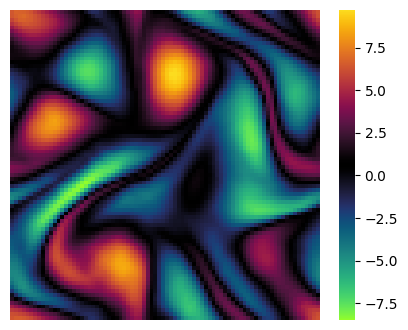

In [19]:
heatmap2d(dec_test[0,0,:,:].cpu().detach().numpy())

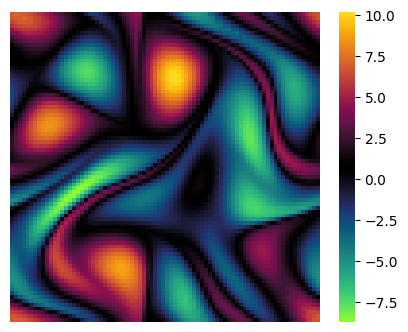

In [20]:
heatmap2d(NS_lowres_tens[solution_index,index_test,:,:].cpu().detach().numpy())

In [23]:
def heatmap2d_grid(u):

  fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(17, 10))

  i = 0
  for ax in axes.flat:
   #   ax.set_axis_off()
      ax.set_xticks([0,40,79], ['-$\pi$', ' 0', '$\pi$'])
      ax.set_yticks([0,40,79], ['-$\pi$', ' 0', '$\pi$'])
      ax.grid(False)
      im = ax.imshow(u[i,:,:], cmap= cmr.wildfire,
                   vmin=-10, vmax=10)
      i += 1

  fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.3, hspace=0.3)

# add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8

  cb_ax = fig.add_axes([0.83, 0.38, 0.01, 0.24])
  cbar = fig.colorbar(im, cax=cb_ax)

  cbar.ax.set_yticks((-10,-5,0,5,10))

  plt.savefig('navier_stokes.png', dpi=700)
  plt.show()

In [24]:
# Evaluate solution over entire time domain

solution_index = np.random.randint(2000,2200,1).squeeze()  # random index in test set
U_test = NS_lowres_tens_0[solution_index,:,:,:]
U_test = torch.unsqueeze(U_test,dim=0)
parameterization_test = parameterization(U_test)


dec_test = np.zeros(shape=(20,80,80))
for num in range(20):
  time_test = torch.unsqueeze(torch.unsqueeze(T[num],dim=0),dim=0).type(torch.float32).to(device)
  enc_test = enc_on_sphere_test(parameterization_test, time_test)
  shift_test = sphere_shift(time_test)
  enc_shifted_test = enc_test + shift_test
  dec_test[num,:,:] = decoder(enc_shifted_test).cpu().detach().numpy()

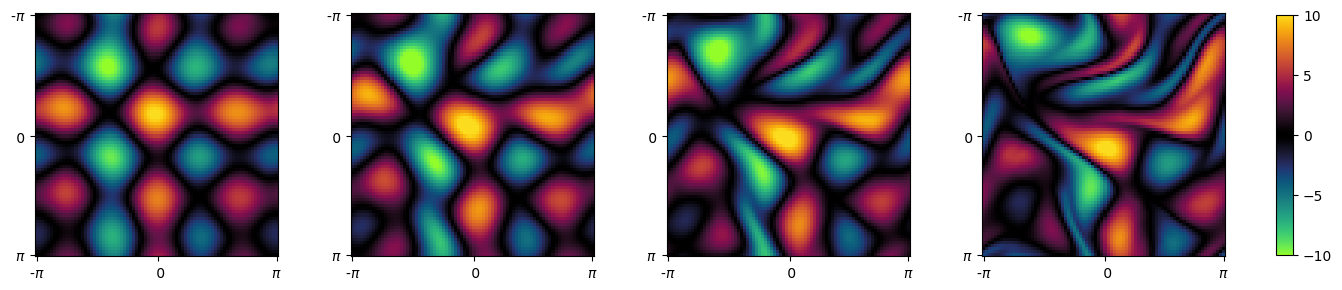

In [25]:
heatmap2d_grid(dec_test[(0,6,12,19),:,:])

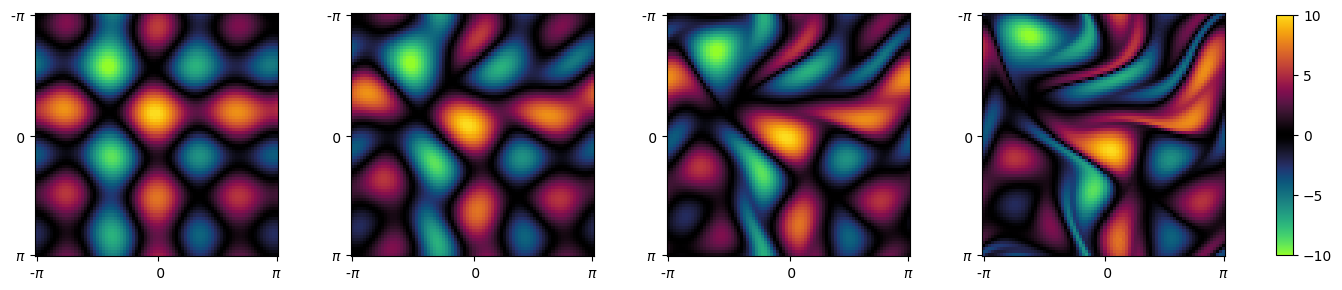

In [26]:
heatmap2d_grid(NS_lowres_tens[solution_index,(0,6,12,19),:,:].cpu().detach().numpy())

In [38]:
# Evaluate test solution with noise

np.random.seed(2)

noise = torch.from_numpy(np.random.normal(0,2.0, size=(25,25))).type(torch.float32).to(device)

solution_index = np.random.randint(2000,2200,1).squeeze()  # Choose test data here, where index \in {test indices}
U_test = NS_lowres_tens_0[solution_index,:,:,:]
U_test[0,40:65,40:65] += noise  # Add in noise
U_test = torch.unsqueeze(U_test,dim=0)

parameterization_test = parameterization(U_test)
index_test = 19 # Choose time index for solution. Should be i i\in [0,19]
time_test = torch.unsqueeze(torch.unsqueeze(T[index_test],dim=0),dim=0).type(torch.float32).to(device)

enc_test = enc_on_sphere_test(parameterization_test, time_test)
shift_test = sphere_shift(time_test)
enc_shifted_test = enc_test + shift_test
dec_test = decoder(enc_shifted_test)

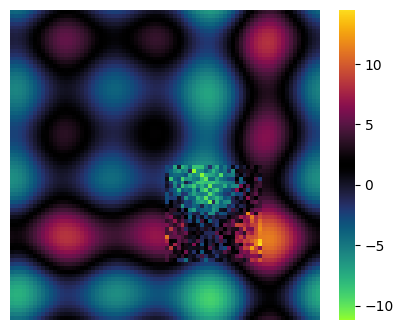

In [39]:
heatmap2d(U_test[0,0,:,:].cpu().detach().numpy())

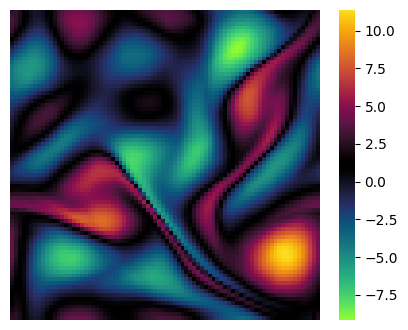

In [40]:
heatmap2d(dec_test[0,0,:,:].cpu().detach().numpy())

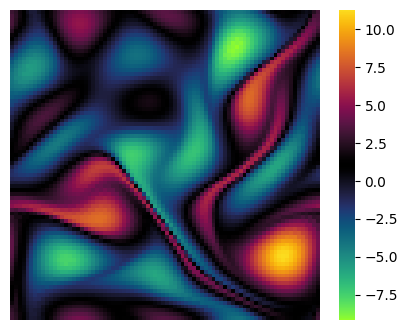

In [41]:
heatmap2d(NS_lowres_tens[solution_index,index_test,:,:].cpu().detach().numpy())